# I. Hướng dẫn

## Khởi tạo Spark

In [61]:
import findspark
findspark.init()

import pyspark
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql.functions import count

spark = (SparkSession
         .builder
         .appName("Classification")
         .getOrCreate())

## Đọc và load tập dữ liệu Iris

In [62]:
irisDF = (spark.read
          .option("HEADER", True)
          .option("inferSchema", True)
          .csv("./data/iris.csv")
         )

irisDF.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|      class|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



## Chuyển cột `class` (kiểu string) thành `label` (kiểu double)

In [63]:
from pyspark.ml.feature import StringIndexer

class_indexer = StringIndexer(inputCol = 'class', outputCol = 'label')

irisDFindexed = class_indexer.fit(irisDF).transform(irisDF)

irisDFindexed.show(5)

+------------+-----------+------------+-----------+-----------+-----+
|sepal_length|sepal_width|petal_length|petal_width|      class|label|
+------------+-----------+------------+-----------+-----------+-----+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|  0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|  0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|  0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|  0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|  0.0|
+------------+-----------+------------+-----------+-----------+-----+
only showing top 5 rows



## Tập dữ liệu Iris

`sepal_length`: chiều dài đài hoa (cm)

`sepal_width`: chiều rộng đài hoa (cm)

`petal_length`: chiều dài cánh hoa (cm)

`petal_width`: chiều rộng cánh hoa (cm)

`class/label`: loại hoa

![Iris dataset](./image/iris.png)

## Chia dữ liệu thành train/test set

In [64]:
(trainDF, testDF) = irisDFindexed.randomSplit([.8, .2], seed = 1)

## Xem các loại biến trong tập dữ liệu

In [65]:
irisDFindexed.dtypes

[('sepal_length', 'double'),
 ('sepal_width', 'double'),
 ('petal_length', 'double'),
 ('petal_width', 'double'),
 ('class', 'string'),
 ('label', 'double')]

## Biến đổi train data và test data theo định dạng của Spark

In [66]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['sepal_length','sepal_width','petal_length','petal_width'],
                            outputCol = 'features')
assembler_train = assembler.transform(trainDF)

X_train = assembler_train.select('features', 'label')
X_train.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[4.3,3.0,1.1,0.1]|  0.0|
|[4.4,2.9,1.4,0.2]|  0.0|
|[4.4,3.0,1.3,0.2]|  0.0|
|[4.4,3.2,1.3,0.2]|  0.0|
|[4.6,3.1,1.5,0.2]|  0.0|
+-----------------+-----+
only showing top 5 rows



## Sử dụng Logistic Regression

### 1.1 Tạo mô hình Logistic Regression

Tạo một một hình Logistic Regression và huấn luyện mô hình trên `X_train` với `labelCol` là `'label'` và `featuresCol` là `'features'`

In [67]:
from pyspark.ml.classification import LogisticRegression

logit = LogisticRegression(featuresCol = "features", labelCol = "label")

logitModel = logit.fit(X_train)

### 1.2. Áp dụng mô hình trên test data

Áp dụng biến đổi cho tập test tương tự như trên tập train. In ra vài dòng sau khi biến đổi để xem kết quả.

In [68]:
assembler_test = assembler.transform(testDF)
X_test = assembler_test.select('features', 'label')
X_test.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[4.5,2.3,1.3,0.3]|  0.0|
|[4.8,3.1,1.6,0.2]|  0.0|
|[4.8,3.4,1.6,0.2]|  0.0|
|[4.8,3.4,1.9,0.2]|  0.0|
|[4.9,2.5,4.5,1.7]|  2.0|
+-----------------+-----+
only showing top 5 rows



Dự đoán trên test data

In [69]:
predictions = logitModel.transform(X_test)
predictions.select("prediction", "label").show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  2.0|
+----------+-----+
only showing top 5 rows



### 1.3. Đánh giá mô hình

Tính giá trị `Accuracy` của mô hình trên tập test

In [70]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.961538
Test Error = 0.0384615


### 1.4. Tạo ML pipeline và đánh giá dùng phương pháp cross validation

In [71]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pprint

pp = pprint.PrettyPrinter(indent = 4)

# Create a LogisticRegression instance. This instance is an Estimator.
logit = LogisticRegression(featuresCol = "features", labelCol = "label")

# Define indexer
indexer = StringIndexer(inputCol = 'class', 
                        outputCol = 'label')

# Define assembler
assembler = VectorAssembler(inputCols = ['sepal_length','sepal_width','petal_length','petal_width'],
                            outputCol = 'features')

# Configure an ML pipeline, which consists of two stages: indexer, assembler, and logit.
pipeline = Pipeline(stages = [indexer, assembler, logit])

# Specify evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol = "label", 
    predictionCol = "prediction",
    metricName = "accuracy"
)

# Specify parameters
paramGrid = (ParamGridBuilder()
            .addGrid(logit.regParam , [0.01, 0.1, 1])
            .build())

# Train/test split
(trainDF, testDF) = irisDF.randomSplit([.8, .2], seed = 1)

# Setup CrossValidator 
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
cv = CrossValidator(estimator = logit, 
                    evaluator = evaluator, 
                    estimatorParamMaps = paramGrid, 
                    numFolds = 3, 
                    parallelism = 2, 
                    seed = 1)

# Run cross-validation on training data, and choose the best set of parameters
logitModel = pipeline.fit(trainDF)

# Make predictions on test data. logitModel uses the best model found (regParam = 0.1)
prediction = logitModel.transform(testDF)
result = prediction.select("features", "label", "prediction").collect()

# Print some predictions
for row in result[0:5]:
    pp.pprint("features=%s, label=%s -> prediction=%s" % 
              (row.features, row.label, row.prediction))

accuracy = evaluator.evaluate(predictions)

print("Test Error = %g" % (1.0 - accuracy))

'features=[4.5,2.3,1.3,0.3], label=2.0 -> prediction=2.0'
'features=[4.8,3.1,1.6,0.2], label=2.0 -> prediction=2.0'
'features=[4.8,3.4,1.6,0.2], label=2.0 -> prediction=2.0'
'features=[4.8,3.4,1.9,0.2], label=2.0 -> prediction=2.0'
'features=[4.9,2.5,4.5,1.7], label=1.0 -> prediction=0.0'
Test Error = 0.0384615


# II. Áp dụng

## Câu 1 - Áp dụng `LogisticRegression` với tập dữ liệu `Auto`

Câu hỏi này sử dụng Logistic Regression trên tập dữ liệu `Auto` để dự đoán một xe cho trước có `mpg` là `high` hay `low`.

**Auto Data Set Description**

A data frame with 392 observations on the following 9 variables.

- `mpg`: miles per gallon

- `cylinders`: Number of cylinders between 4 and 8

- `displacement`: Engine displacement (cu. inches)

- `horsepower`: Engine horsepower

- `weight`: Vehicle weight (lbs.)

- `acceleration`: Time to accelerate from 0 to 60 mph (sec.)

- `year`: Model year (modulo 100)

- `origin`: Origin of car (1. American, 2. European, 3. Japanese)

- `name`: Vehicle name

**1.1.** Tạo một binary variable nhận giá trị 1 (`high`) với các xe có `mpg` lớn hơn median mpg, và nhận giá trị 0 (`low`) cho các xe còn lại.

- Đọc dữ liệu từ file Auto.csv

In [72]:
AutoDF = (spark.read
          .option("HEADER", True)
          .option("inferSchema", True)
          .csv("./data/Auto.csv")
         )

AutoDF.show(5)

+----+---------+------------+----------+------+------------+----+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|year|origin|                name|
+----+---------+------------+----------+------+------------+----+------+--------------------+
|18.0|        8|       307.0|       130|  3504|        12.0|  70|     1|chevrolet chevell...|
|15.0|        8|       350.0|       165|  3693|        11.5|  70|     1|   buick skylark 320|
|18.0|        8|       318.0|       150|  3436|        11.0|  70|     1|  plymouth satellite|
|16.0|        8|       304.0|       150|  3433|        12.0|  70|     1|       amc rebel sst|
|17.0|        8|       302.0|       140|  3449|        10.5|  70|     1|         ford torino|
+----+---------+------------+----------+------+------------+----+------+--------------------+
only showing top 5 rows



- Tính median và tính high, low

In [73]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Calculate the median of `mpg`
median = AutoDF.approxQuantile('mpg', [0.5], 0.25)[0]

# Define the function to return 0 or 1 based on median of `mpg` attribbute
def alternate_with_med(x):
    return 0 if x < median else 1

# Call function and load into DataFrame with new column name `label`
Alter_udf = udf(alternate_with_med, IntegerType())
AutoDF = AutoDF.withColumn('label', Alter_udf(AutoDF['mpg']))

AutoDF.show(5)

+----+---------+------------+----------+------+------------+----+------+--------------------+-----+
| mpg|cylinders|displacement|horsepower|weight|acceleration|year|origin|                name|label|
+----+---------+------------+----------+------+------------+----+------+--------------------+-----+
|18.0|        8|       307.0|       130|  3504|        12.0|  70|     1|chevrolet chevell...|    1|
|15.0|        8|       350.0|       165|  3693|        11.5|  70|     1|   buick skylark 320|    0|
|18.0|        8|       318.0|       150|  3436|        11.0|  70|     1|  plymouth satellite|    1|
|16.0|        8|       304.0|       150|  3433|        12.0|  70|     1|       amc rebel sst|    0|
|17.0|        8|       302.0|       140|  3449|        10.5|  70|     1|         ford torino|    0|
+----+---------+------------+----------+------+------------+----+------+--------------------+-----+
only showing top 5 rows



**1.2.** Áp dụng Logistic Regression cho tập dữ liệu với các giá trị siêu tham số `regParam` khác nhau để dự đoán `mpg`. Cho biết cross-validation error ứng với các giá trị khác nhau của siêu tham số này. Nhận xét kết quả thu được. Tham khảo document về Logistic Regression của Spark ở [LogisticRegression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html#pyspark.ml.classification.LogisticRegression).

- Tạo ML pipeline dùng phương pháp Cross Validation, ParamGrid thử các siêu tham số khác nhau.

In [74]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pprint

pp = pprint.PrettyPrinter(indent = 4)

# Create a LogisticRegression instance. This instance is an Estimator.
logit = LogisticRegression(featuresCol = "features", labelCol = "label")

# Define assembler
assembler = VectorAssembler(inputCols = ['cylinders','displacement', 'weight','acceleration','year','origin'],
                            outputCol = 'features')

# Configure an ML pipeline, which consists of two stages: indexer, assembler, and logit.
pipeline = Pipeline(stages = [ assembler, logit])

# Specify evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol = "label", 
    predictionCol = "prediction",
    metricName = "accuracy"
)

# Specify parameters
paramGrid = (ParamGridBuilder()
            .addGrid(logit.regParam , [0.01, 0.05, 0.1, 0.5, 1])
            .build())

# Train/test split
(trainDF, testDF) = AutoDF.randomSplit([.8, .2], seed = 1)

# Setup CrossValidator 
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
cv = CrossValidator(estimator = pipeline, 
                    evaluator = evaluator, 
                    estimatorParamMaps = paramGrid, 
                    numFolds = 3, 
                    parallelism = 2, 
                    seed = 1)

# Run cross-validation on training data, and choose the best set of parameters
logitModel = cv.fit(trainDF)

# Make predictions on test data. logitModel uses the best model found (regParam = 0.1)
logistic_prediction = logitModel.transform(testDF)
result = logistic_prediction.select("features", "label", "prediction").collect()

# Print some predictions
for row in result[0:5]:
    pp.pprint("features=%s, label=%s -> prediction=%s" % 
              (row.features, row.label, row.prediction))

accuracy = evaluator.evaluate(logistic_prediction)

print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

'features=[8.0,350.0,3664.0,11.0,73.0,1.0], label=0 -> prediction=0.0'
'features=[8.0,302.0,3169.0,12.0,75.0,1.0], label=0 -> prediction=1.0'
'features=[8.0,302.0,3870.0,15.0,76.0,1.0], label=0 -> prediction=0.0'
'features=[8.0,302.0,4294.0,16.0,72.0,1.0], label=0 -> prediction=0.0'
'features=[8.0,318.0,3755.0,14.0,76.0,1.0], label=0 -> prediction=0.0'
Accuracy = 0.894737
Test Error = 0.105263


#### Nhận xét:
Accuracy của mô hình Logistic Regression với các tham số như trên là: 0.894737, tương đương khoảng  89.4737%, một mức độ chính xác có thể xem là khá cao.

## Câu 2 - So sánh các mô hình phân loại

Thực hiện việc train tất cả các mô hình `LogisticRegression`, `DecisionTreeClassifier` và `RandomForestClassifier`, `GBTClassifier`, `MultilayerPerceptronClassifier`, `LinearSVC`, `NaiveBayes` trên tập dữ liệu HeartDisease (https://archive.ics.uci.edu/ml/datasets/heart+Disease). Điều chỉnh các siêu tham số của các mô hình để chọn mô hình tốt nhất dùng cross validation. So sánh và nhận xét về kết quả của các mô hình. Để tránh lặp lại các bước xử lý giống nhau nhiều lần như ở trên bạn nên tạo pipeline các bước xử lý. Tham khảo cách tạo pipeline cho mô hình ở [đây](https://spark.apache.org/docs/latest/ml-pipeline.html). Tham khảo document về các classifier của Spark ở [classification module](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#classification).

Bên dưới là một số gợi ý.

In [75]:
heart = (spark.read
          .option("HEADER", True)
          .option("inferSchema", True)
          .csv("./data/HeartDisease.csv")
         )

heart.show(5)

+---+---+---+------------+------+----+---+-------+-----+-----+-------+-----+---+----------+---+
|_c0|Age|Sex|   ChestPain|RestBP|Chol|Fbs|RestECG|MaxHR|ExAng|Oldpeak|Slope| Ca|      Thal|AHD|
+---+---+---+------------+------+----+---+-------+-----+-----+-------+-----+---+----------+---+
|  1| 63|  1|     typical|   145| 233|  1|      2|  150|    0|    2.3|    3|  0|     fixed| No|
|  2| 67|  1|asymptomatic|   160| 286|  0|      2|  108|    1|    1.5|    2|  3|    normal|Yes|
|  3| 67|  1|asymptomatic|   120| 229|  0|      2|  129|    1|    2.6|    2|  2|reversable|Yes|
|  4| 37|  1|  nonanginal|   130| 250|  0|      0|  187|    0|    3.5|    3|  0|    normal| No|
|  5| 41|  0|  nontypical|   130| 204|  0|      2|  172|    0|    1.4|    1|  0|    normal| No|
+---+---+---+------------+------+----+---+-------+-----+-----+-------+-----+---+----------+---+
only showing top 5 rows



In [76]:
heart.count()

303

In [77]:
len(heart.columns)

15

In [78]:
heart.dtypes

[('_c0', 'int'),
 ('Age', 'int'),
 ('Sex', 'int'),
 ('ChestPain', 'string'),
 ('RestBP', 'int'),
 ('Chol', 'int'),
 ('Fbs', 'int'),
 ('RestECG', 'int'),
 ('MaxHR', 'int'),
 ('ExAng', 'int'),
 ('Oldpeak', 'double'),
 ('Slope', 'int'),
 ('Ca', 'string'),
 ('Thal', 'string'),
 ('AHD', 'string')]

In [79]:
from pyspark.sql.functions import when

# Add new colummn with Label to classification
heart = heart.withColumn("label", when(heart.AHD == "No", 0)
                                 .when(heart.AHD == "Yes", 1))

In [80]:
heart.withColumn('Ca', heart.Ca.cast('int'))

DataFrame[_c0: int, Age: int, Sex: int, ChestPain: string, RestBP: int, Chol: int, Fbs: int, RestECG: int, MaxHR: int, ExAng: int, Oldpeak: double, Slope: int, Ca: int, Thal: string, AHD: string, label: int]

## Build pipiline for model  

Build pipeline with cross validation, paramGrid

In [81]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import when

import pprint
pp = pprint.PrettyPrinter(indent = 4)

catInputCols = ['ChestPain', 'RestECG', 'Slope', 'Thal']
catOutputCols = [x + "Index" for x in catInputCols]
oheCatOutputCols = [x + "OHE" for x in catInputCols]

catIndexer = StringIndexer(inputCols = catInputCols, outputCols = catOutputCols)

catOHEncoder = OneHotEncoder(inputCols = catOutputCols, 
                          outputCols = oheCatOutputCols)

# Define assembler
assembler = VectorAssembler(inputCols = ['ChestPainOHE','RestECGOHE','SlopeOHE','Age','Sex',
                                         'RestBP','Chol','Fbs','MaxHR','ExAng','Oldpeak'],
                            outputCol = 'features')

# Train/test split
(trainDF, testDF) = heart.randomSplit([.8, .2], seed = 1)

# view the transformed data
# transformed_heart = pipelineModel.transform(heart)
# transformed_heart.select(catInputCols + oheCatOutputCols).show(5)

# Specify evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol = "label", 
    predictionCol = "prediction",
    metricName = "accuracy"
)


### 1 - Logistic Regression

In [82]:
# Create a LogisticRegression instance. This instance is an Estimator.
logit = LogisticRegression(featuresCol = "features", labelCol = "label")

pipeline = Pipeline(stages = [catIndexer, catOHEncoder, assembler, logit])

# Specify parameters
paramGrid = (ParamGridBuilder()
            .addGrid(logit.regParam , [0.01, 0.05, 0.1, 0.5, 1])
            .build())

cv = CrossValidator(estimator = pipeline, 
                    evaluator = evaluator, 
                    estimatorParamMaps = paramGrid, 
                    numFolds = 3, 
                    parallelism = 2, 
                    seed = 1234)

# Run cross-validation on training data, and choose the best set of parameters
logitModel = cv.fit(trainDF)

# Make predictions on test data. logitModel uses the best model found (regParam = 0.1)
log_prediction = logitModel.transform(testDF)
result = prediction.select("features", "label", "prediction").collect()

# # Print some predictions
# for row in result[0:5]:
#     pp.pprint("features=%s, label=%s -> prediction=%s" % 
#               (row.features, row.label, row.prediction))

logit_accuracy = evaluator.evaluate(log_prediction)

print("Logistic Test Error = %g" % (1.0 - logit_accuracy))

Logistic Test Error = 0.338983


### 2 - Decision Tree Classifier


In [83]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create a DecisionTreeClassifier instance. This instance is an Estimator.
decision = DecisionTreeClassifier(featuresCol = "features", labelCol = "label")

pipeline = Pipeline(stages = [catIndexer, catOHEncoder, assembler, decision])

# Specify parameters
paramGrid = (ParamGridBuilder()
            .addGrid(decision.maxDepth , [2, 5, 10, 20, 30])
            .addGrid(decision.maxBins , [10, 20, 40, 80, 100])
            .build())

cv = CrossValidator(estimator = pipeline, 
                    evaluator = evaluator, 
                    estimatorParamMaps = paramGrid, 
                    numFolds = 3, 
                    parallelism = 2, 
                    seed = 1)

# Run cross-validation on training data, and choose the best set of parameters
decisionModel = cv.fit(trainDF)

# Make predictions on test data. Decisionmodel uses the best model found (maxDepth = 0.1)
dec_prediction = decisionModel.transform(testDF)
result = prediction.select("features", "label", "prediction").collect()

# # Print some predictions
# for row in result[0:2]:
#     pp.pprint("features=%s, label=%s -> prediction=%s" % 
#               (row.features, row.label, row.prediction))

decision_accuracy = evaluator.evaluate(dec_prediction)

print("Decision Test Error = %g" % (1.0 - decision_accuracy))

Decision Test Error = 0.338983


### 3 - Random Forest Classifier

In [84]:
from pyspark.ml.classification import RandomForestClassifier

# Create a RandomForestClassifier instance
rforest = RandomForestClassifier(featuresCol = "features", labelCol = "label")

# Create a ML pipeline
pipeline = Pipeline(stages = [catIndexer, catOHEncoder, assembler, rforest])

# Specify parameters
paramGrid = (ParamGridBuilder()
            .addGrid(rforest.maxDepth, [5, 10, 20, 30])
            .addGrid(rforest.maxBins, [5, 10, 20, 30])
            .addGrid(rforest.numTrees, [5, 10, 20, 30])
            .build())

cv = CrossValidator(estimator = pipeline, 
                    evaluator = evaluator, 
                    estimatorParamMaps = paramGrid, 
                    numFolds = 3, 
                    parallelism = 2, 
                    seed = 1)

# Run cross-validation on traning data, and choose the best set of parameters
rfModel = cv.fit(trainDF)

# Make predictions on test data. RandomForest model use the best model found
rf_prediction = rfModel.transform(testDF)
result = prediction.select("features", "label", "prediction").collect()

# # Print some predictions
# for row in result[0:2]:
#     pp.pprint("features=%s, label=%s -> prediction=%s" %
#              (row.features, row.label, row.prediction))

rf_accuracy = evaluator.evaluate(rf_prediction)

print("Random Forest Test Error = %g" % (1.0 - rf_accuracy))

Random Forest Test Error = 0.372881


### 4 - Gradient-boosted tree Classifier

In [85]:
from pyspark.ml.classification import GBTClassifier

# Create a Gradient-boosted tree classifer instance
GBT = GBTClassifier(featuresCol = "features", labelCol = "label")

# Create a ML pipeline
pipeline = Pipeline(stages = [catIndexer, catOHEncoder, assembler, GBT])

# Specify parameters
paramGrid = (ParamGridBuilder()
             .addGrid(GBT.maxDepth, [2, 5, 10])
             .addGrid(GBT.maxBins, [10, 20, 40])
             .addGrid(GBT.maxIter, [5, 10, 20])
             .build())

cv = CrossValidator(estimator = pipeline, 
                    evaluator = evaluator, 
                    estimatorParamMaps = paramGrid, 
                    numFolds = 3, 
                    parallelism = 2, 
                    seed = 1)

# Run cross-validation on traning data, and choose the best set of parammters
GBTclassifer = cv.fit(trainDF)

# Make predctions on test data. Gradient-boosted model use the best model found
gbt_prediction = GBTclassifer.transform(testDF)
result = prediction.select("features", "label", "prediction").collect()

# # Print some predictions
# for row in result[0:2]:
#     pp.pprint("feature=%s | label=%s -> predcition=%s" %
#               (row.features, row.label, row.prediction))
    
GBT_accuracy = evaluator.evaluate(gbt_prediction)

print("GBT Classifer Test Error = %g" % (1.0 - GBT_accuracy))

GBT Classifer Test Error = 0.355932


### 5 - MultilayerPerceptronClassifier

In [86]:
# from pyspark.ml.classification import MultilayerPerceptronClassifier

# mcpc = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', 
#                                       maxIter= 100, layers=[10, 11, 10, 3])

# # add parameter grid 
# paramGrid = ParamGridBuilder().build()

# # Create a  MLpipeline
# pipeline = Pipeline(stages = [catIndexer, catOHEncoder, assembler, mcpc])

# # Setup CrossValidator 
# # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# cv = CrossValidator(estimator = pipeline, 
#                     evaluator = evaluator, 
#                     estimatorParamMaps = paramGrid, 
#                     numFolds = 3, 
#                     parallelism = 2, 
#                     seed = 1)

# # Run cross-validation on training data, and choose the best set of parameters
# MLClassifier = cv.fit(trainDF)

# # Make predictions on testing data, MultilayerPerceptron model use the best model found
# ml_prediction = MLClassifier.transform(testDF)
# result = ml_prediction.select("features", "label", "prediction").collect()

# # Print some predictions
# for row in result[0:2]:
#     pp.pprint("features=%s | label=%s -> prediction=%s" %
#               (row.features, row.label, row.prediction))
    
# MLClassifier_accuracy = evaluator.evaluate(ml_prediciton)

# print("Multilayer Perceptron Test Error = %g" % (1.0 - MLClassifier_accuracy))

###  6 - NaiveBayes Classification

In [87]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol = "features", labelCol = "label")

# Create a pipeline 
pipeline = Pipeline(stages = [catIndexer, catOHEncoder, assembler, nb])

# Specify parameters
paramGrid = (ParamGridBuilder()
            .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8])
            .build())

# A cross-validation requires an Estimator,...
cv = CrossValidator(estimator = pipeline,
                    evaluator = evaluator,
                    estimatorParamMaps = paramGrid,
                    numFolds = 3,
                    parallelism = 2,
                    seed = 1)

# Run predictions on training data, and choose the best of set parameters
NaiveBayes = cv.fit(trainDF)

# Make predictions testing data, Naiva Bayes model use the best model found
nb_prediction = NaiveBayes.transform(testDF)
result = prediction.select("features", "label", "prediction")

# for row in result[0:2]:
#     pp.pprint("features=%s | label=%s -> prediction=%s" %
#               (row.features, row.label, row.prediction))

nb_accuracy = evaluator.evaluate(nb_prediction)

print("Naive Bayes Test Error = %g" % (1.0 - nb_accuracy))

Naive Bayes Test Error = 0.305085


### 7 - Linear Support Vector Machine

In [88]:
from pyspark.ml.classification import LinearSVC

linearSVC = LinearSVC(featuresCol = "features", labelCol = "label")
 # Create a ML pipeline 
pipeline = Pipeline(stages = [catIndexer, catOHEncoder, assembler, linearSVC])

# Specify parameters
paramGrid = (ParamGridBuilder()
            .addGrid(linearSVC.maxIter, [10, 20, 30, 40])
            .addGrid(linearSVC.regParam, [0.01, 0.1, 0.5, 1 ])
            .build())

# Set cross-validation
cv = CrossValidator(estimator = pipeline,
                    evaluator = evaluator,
                    estimatorParamMaps = paramGrid,
                    numFolds = 3,
                    parallelism = 2,
                    seed = 1)

# Run prediction on traning data,
LinearSVC = cv.fit(trainDF)

# Make Prediction on testing data
SVC_prediction = NaiveBayes.transform(testDF)
result = SVC_prediction.select("features", "label", "prediction")

# # Print some predictions
# for row in result[0:2]:
#     pp.pprint("feature=%s | label=%s -> predcition=%s" %
#               (row.features, row.label, row.prediction))

linearSVC_accuracy = evaluator.evaluate(SVC_prediction)

print("Naive Bayes Test Error = %g" % (1.0 - linearSVC_accuracy))

Naive Bayes Test Error = 0.305085


### So sánh kết quả của các mô hình

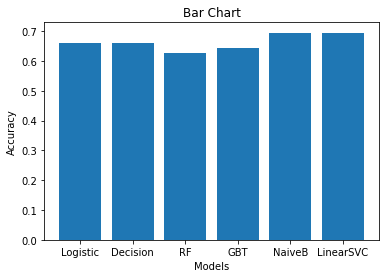

In [89]:
import matplotlib.pyplot as plt

x = ['Logistic', 'Decision', 'RF', 'GBT', 'NaiveB', 'LinearSVC']
y = [logit_accuracy, decision_accuracy, rf_accuracy, GBT_accuracy, nb_accuracy, linearSVC_accuracy]

# Bar chart with day against tip
plt.bar(x, y)

plt.title("Bar Chart")

# Setting the X and Y labels
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Adding the legends
plt.show()


#### Nhận xét: 
- Hai mô hình cuối Naive Bayes và Linear SVC cho kết quả tốt hơn các mô hình còn lại. Nhưng nhìn chung, kết quá của tất cả các mô hình chưa được tốt, phần này có liên quan đến xử lí dữ liệu.

## Câu 3 - So sánh các mô hình hồi quy

Thực hiện việc train tất cả các mô hình `LinearRegression`, `DecisionTreeRegression` và `RandomForestRegression`, `GBTRegression` trên tập một tập dữ liệu cho bài toán hồi quy (có 10-100 thuộc tính gồm cả thuộc tính phân loại và thuộc tính số và có 100-1000 đối tượng) mà bạn quan tâm ở [UCI Regression Dataset](https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=10to100&numIns=100to1000&type=&sort=nameUp&view=table). Điều chỉnh các siêu tham số của các mô hình để chọn mô hình tốt nhất dùng cross validation. Để tránh lặp lại các bước xử lý giống nhau nhiều lần như ở trên bạn nên tạo pipeline các bước xử lý. Tham khảo cách tạo pipeline cho mô hình ở [đây](https://spark.apache.org/docs/latest/ml-pipeline.html). Tham khảo document về các classifier của Spark ở [regression module](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#regression).

In [90]:
# Viết code của bạn ở đây
